In [1]:
! pip install --upgrade google-cloud-bigquery-storage

In [2]:
import google, numpy as np, pandas as pd, geopandas as gpd, networkx as nx
from google.cloud import aiplatform, bigquery
from google.cloud.bigquery_storage import BigQueryReadClient, types
cred, proj = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
bqclient = bigquery.Client(credentials = cred, project = proj)

In [3]:
yr = 2017
state_abbr = 'RI'
proj_id = 'cmat-315920'
min_degree = 4

crs_orig   = 'NAD83'
crs_area   = 'ESRI:102003'
crs_length = 'ESRI:102005'

In [4]:
query_str = f"""
select
    state_fips_code as fips
    , state_postal_abbreviation as abbr
    , state_name as name
from
    bigquery-public-data.census_utility.fips_codes_states
"""
states = bqclient.query(query_str).result().to_dataframe()
state = states[states['abbr']==state_abbr].iloc[0]
state

def yr_to_congress(yr):
    return int((yr-1786)/2)

def congress_to_yr(congress):
    return 1786 + 2 * congress

congress = yr_to_congress(yr)

In [5]:
# %%time
# input is WKT in NAD83 - https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2020/TGRSHP2020_TechDoc_Ch3.pdf
# use ESRI:102003 for area calculations - https://epsg.io/102003
# use ESRI:102005 for length calculations - https://epsg.io/102005
# geo_id structure - https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html

class myGeoDataFrame(gpd.GeoDataFrame):
    def set_crs(self, crs):
        self['centroid'] = self['centroid'].to_crs(crs)
        self.to_crs(crs, inplace=True)
        return self

    def get_perim(self, col=None):
        X = self.set_crs(crs_length)
        if col:
            X = self.dissolve(by=col)
        return X.length

    def get_area(self, col=None):
        X = self.set_crs(crs_area)
        if col:
            X = X.dissolve(by=col)
        return X.area

def get_data(fips):
    query_str = f"""
    select
        geo.geo_id
        , cast(substring(geo.geo_id, 0 , 2) as int) as state_fips
        , cast(substring(geo.geo_id, 3 , 3) as int) as county_fips
        , cast(substring(geo.geo_id, 5 , 6) as int) as tract_ce
        , cast(substring(geo.geo_id, 12, 1) as int) as blockgroup_ce
        , centroids.lon
        , centroids.lat
        , cast(cd.cd as int) as cd
        , cast(acs.total_pop as int) as pop
        , geo.geometry
    from (
        -- get shapes
        select
            geo_id
            --state_fips_code as state_fips
            --, county_fips_code as county_fips
            --, tract_ce
            --, blockgroup_ce
            --, lsad_name
            --, mtfcc_feature_class_code.
            --, functional_status
            --, area_land_meters
            --, area_water_meters
            --, internal_point_lat as lat
            --, internal_point_lon aas loni
            --, internal_point_geom
            , blockgroup_geom as geometry
        from
            bigquery-public-data.geo_census_blockgroups.blockgroups_{fips}
        )  as geo
    inner join (
        -- get shapes demographic data
        select distinct
            geo_id
            , total_pop
        from
            bigquery-public-data.census_bureau_acs.blockgroup_{yr}_5yr
        ) as acs
    on
        geo.geo_id = acs.geo_id
    inner join (
        -- get population weighted centroids
        -- must build geo_id because data source does not include it
        select distinct
            concat( 
                lpad(cast(STATEFP as string), 2, "0"),
                lpad(cast(COUNTYFP as string), 3, "0"),
                lpad(cast(TRACTCE as string), 6, "0"),
                lpad(cast(BLKGRPCE as string), 1, "0")
                ) as geo_id
            --, POPULATION as pop
            , LONGITUDE as lon
            , LATITUDE as lat
        from
            {proj_id}.BLOCK_CENTROIDS.block_centroid_{fips}
        ) as centroids
    on
        geo.geo_id = centroids.geo_id
    inner join (
        -- get congressional district
        -- at block level -> must aggregate to blockgroup
        -- 7141 (3%) of blockgroups span multiple congressional districts
        -- We assign that entire bg to the cd with the most blocks
        select
            *
        from (
            select
                A.*
                , rank() over (partition by A.geo_id order by A.num_blocks_in_cd desc) as r
            from (
                select
                    left(BLOCKID, 12) as geo_id   -- remove last 4 char to get blockgroup geo_id
                    , CD{congress} as cd
                    , count(*) as num_blocks_in_cd
                from 
                    {proj_id}.Block_Equivalency_Files.{congress}th_BEF
                group by
                    1, 2
                ) as A
            ) as B
        where
            r = 1
        ) as cd
    on
        geo.geo_id = cd.geo_id
    """
    df = bqclient.query(query_str).result().to_dataframe().set_index('geo_id')
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
    df = myGeoDataFrame(df, geometry='geometry', crs=crs_orig)
    df['centroid'] = gpd.points_from_xy(df['lon'], df['lat'], crs=crs_orig)
    df['area'] = df.get_area()
    df['perim'] = df.get_perim()
    return df.set_crs(crs_length)

df = get_data(state['fips'])

<AxesSubplot:>

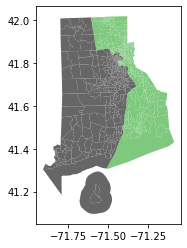

In [8]:
df.set_crs(crs_orig).plot('cd',cmap='Accent')

In [45]:
def get_graph(df, min_degree=4):
    cols = ['geo_id', 'geometry', 'centroid']
    A = df.reset_index().query('pop > 0')[cols]
    pairs = A.merge(A, how='cross').query('geo_id_x < geo_id_y').reset_index(drop=True)
    pairs['distance']     = pairs.set_geometry('centroid_x').distance(    pairs.set_geometry('centroid_y'), align=False)
    pairs['perim_shared'] = pairs.set_geometry('geometry_x').intersection(pairs.set_geometry('geometry_y'), align=False).length
    pairs['touch'] = pairs['perim_shared'] > 1
    pairs['transit_time'] = pairs['distance'] / 1341 * rng.uniform(0.5, 1.5)  # 50 mph → 1341 m/min
    pairs.drop(columns=[c+z for c in cols[1:] for z in ['_x', '_y']], inplace=True)

    pairs = pd.concat([pairs, pairs.rename(columns={'geo_id_x':'geo_id_y', 'geo_id_y':'geo_id_x'})])
    pairs['degree_orig'] = pairs.groupby('geo_id_x')['touch'].transform('sum')
    pairs.sort_values(by=['degree_orig', 'geo_id_x', 'touch','distance'], ascending=[True, True, False, True], inplace=True)

    def f(x):
        if x['touch'].sum() >= min_degree:
            return x.query('touch==True')
        return x.head(min_degree)
    edges = (pairs.groupby('geo_id_x').apply(f)
             .reset_index(drop=True)
             .sort_values(by=['degree_orig', 'geo_id_x', 'touch','distance'], ascending=[True, True, False, True])
             .reset_index(drop=True)
            )
    edges['degree'] = edges.groupby('geo_id_x')['touch'].transform(lambda x: len(x))
    edge_attr = ['perim_shared', 'touch', 'distance', 'transit_time']
    node_attr = ['area', 'perim', 'cd', 'pop']
    G = nx.from_pandas_edgelist(edges, source='geo_id_x', target='geo_id_y', edge_attr=edge_attr)
    nx.set_node_attributes(G, df[node_attr].to_dict('index'))
    return pairs, G


    

rng = np.random.default_rng(42)
pairs, G = get_graph(df, min_degree)
display(pairs.head(8))
display(pairs.tail(8))

,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
146299,440050401033,440050401035,4318.182916,0.0,False,4.102293,0
146296,440050401033,440050401034,5074.047397,0.0,False,4.820368,0
131447,440050401033,440050401012,5307.062912,0.0,False,5.041734,0
141943,440050401033,440050401023,5714.273217,0.0,False,5.428585,0
146300,440050401033,440050401036,6131.167121,0.0,False,5.824636,0
24703,440050401033,440010308003,6345.336941,0.0,False,6.028099,0
146263,440050401033,440050403031,6650.850855,0.0,False,6.318338,0
138862,440050401033,440050401032,6653.089816,0.0,False,6.320465,0


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
174152,440090513041,440070182001,66672.428979,0.0,False,63.339108,11
170496,440090513041,440070173001,66735.168245,0.0,False,63.398711,11
310938,440090513041,440070184005,66738.436498,0.0,False,63.401816,11
180036,440090513041,440070181001,66768.483221,0.0,False,63.430360,11
157516,440090513041,440070184001,66889.264292,0.0,False,63.545103,11
227376,440090513041,440070181002,66927.361103,0.0,False,63.581295,11
273914,440090513041,440070184003,67158.481278,0.0,False,63.800860,11
182409,440090513041,440070114021,67206.353769,0.0,False,63.846339,11


In [97]:
def check_connected(G):
    for cd in set(dict(G.nodes(data='cd')).values()):
#         c = nx.number_connected_components(nx.subgraph_view(G, filter_node=lambda n: G.nodes[n].get('cd') == cd))
#         while True:
        for i in range(30):
            cc = list(nx.connected_components(nx.subgraph_view(G, filter_node=lambda n: G.nodes[n].get('cd') == cd)))
            if len(cc) == 1:
                break
            print(f'DISCONNECTED CD DETECTED - {state["name"]} congressional district {cd} has {len(cc)} components')
            cc = sorted(cc, key=len)
            c0, c1 = cc[:2]
#             print(c0)
#             print(c1)
            mask = pairs['geo_id_x'].isin(c0) & pairs['geo_id_y'].isin(c1)
            i = pairs.loc[mask, 'distance'].idxmin()
            display(pairs.loc[i])
#             display(pairs.loc[mask, 'distance'])
#             pairs.query(f'geo_id_x.isin({c0})')
            print([len(c) for c in cc])
            
    
#         assert c == 1, f'DISCONNECTED CD DETECTED - {state["name"]} congressional district {cd} has {c} components'
c = check_connected(G)
c

DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
DISCONNECTED CD DETECTED - Rhode Island congressional district 1 has 2 components


,geo_id_x,geo_id_y,distance,perim_shared,touch,transit_time,degree_orig
27812,440010308004,440050401013,2904.228109,0.0,False,2.75903,4
27812,440050401013,440010308004,2904.228109,0.0,False,2.75903,4


[59, 354]
